In [12]:
import qutip
import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian Evolution with a Pulse Sequence: A 1D array example

We shall emulate using qutip a series of pulse sequences created with Pulser

In [88]:
try:
    import pulser
except ModuleNotFoundError:
    import sys
    sys.path.insert(1, '../')

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2

In [162]:
# Three-state basis:
r = qutip.basis(3,0)
g = qutip.basis(3,1)
h = qutip.basis(3,2)

In [176]:
# Basic transition operators:
I = qutip.qeye(3)

sigma_gr = r*g.dag() + g*r.dag() + h*h.dag()
rydY = -1j*r*g.dag() + 1j*g*r.dag() + h*h.dag()
rydZ = r*r.dag() - g*g.dag()

sigma_gh = h*g.dag() + g*h.dag() + r*r.dag()
excY = 1j*h*g.dag() - 1j*g*h.dag() + r*r.dag()
excZ = -h*h.dag() + g*g.dag()

sigma_rr = r*r.dag()
sigma_gg = h*h.dag()
sigma_hh = g*g.dag()

In [177]:
excZ

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]

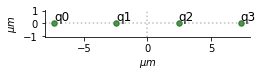

In [178]:
# Atom Register
L = 4
reg1 = Register.rectangle(1, L, spacing=4.9,prefix='q')
reg1.draw()  


In [179]:
#Define Device 
device = Chadoq2(reg1) 

In [180]:
#Define sequence and Set channels
seq = Sequence(device)
seq.declare_channel('local', 'raman_local')
seq.declare_channel('global', 'rydberg_global')

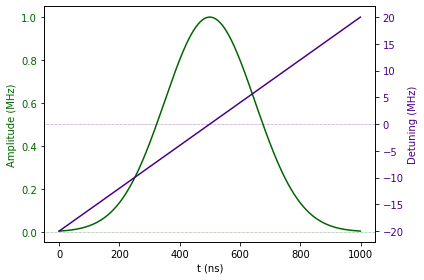

In [62]:
#Create waveforms and pulse
from pulser.waveforms import RampWaveform, GaussianWaveform

duration = 1000
amp_wf = GaussianWaveform(duration, 1, 150)   # Duration: 1000 ns, Max Amp: 1 MHz, Stdev: 150 ns
detuning_wf = RampWaveform(duration, -20, 20)  # Duration: 1000ns, linear sweep from -20 to 20 MHz

complex_pulse = Pulse(amp_wf, detuning_wf, phase=20)
complex_pulse.draw()

In [63]:
seq.target('q1','local')
seq.add(complex_pulse, 'local')
seq.add(complex_pulse, 'global')

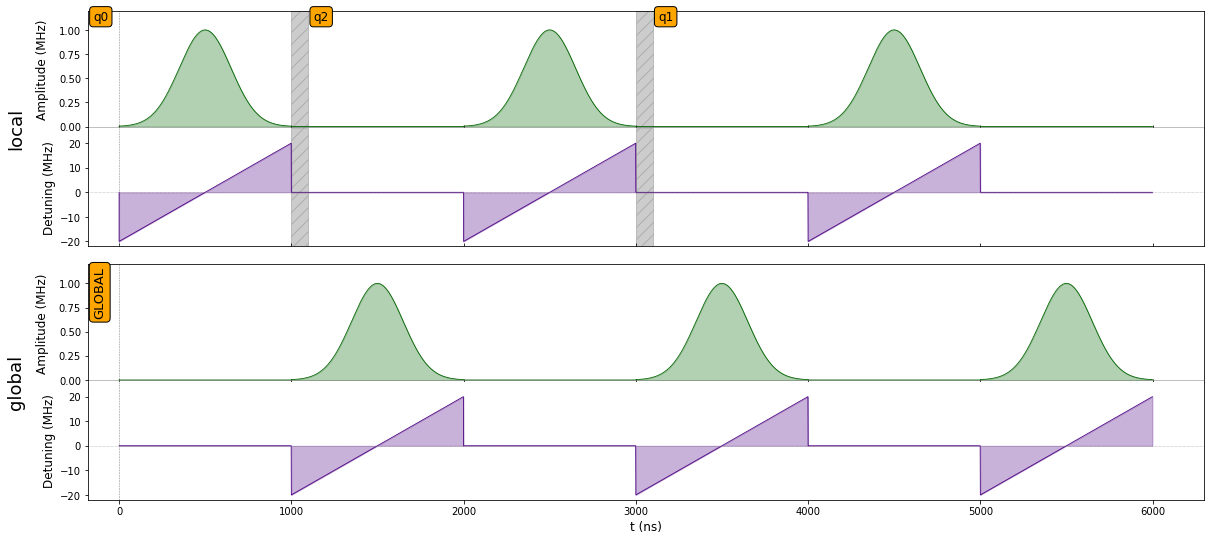

In [64]:
seq.draw()

Now that we have the pulse sequence, we emulate the evolution of the atom array using Qutip

In [102]:
#Define Operators

def local_operator(qubit_id,operator):
    """
    Returns a local gate at a qubit
    """
    temp = [qutip.qeye(3) for _ in range(L)]
    pos =  reg1._ids.index(qubit_id)
    temp[pos] = operator
    return qutip.tensor(temp)

def two_body_operator(qubit_id1, qubit_id2, operator):
    """
    Returns a local gate at a qubit
    """
    if qubit_id1 == qubit_id2:
        raise ValueError("Same Atom ID given for a Two-body operator")

    temp = [qutip.qeye(3) for _ in range(L)]
    pos1 =  reg1._ids.index(qubit_id1)
    pos2 =  reg1._ids.index(qubit_id2)
    temp[pos1] = operator
    temp[pos2] = operator
    
    return qutip.tensor(temp)

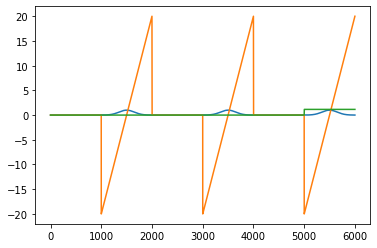

In [146]:
#Extract pulse samples for global channel
global_amp = []
global_det = []
global_phase = []

for x in seq._schedule['global']:
    obj = x.type
    if type(obj) == Pulse:
        for t in range(obj.duration): 
            global_amp.append(obj.amplitude.samples[t])
            global_det.append(obj.detuning.samples[t])
            global_phase.append(obj.phase)
    elif obj == 'delay':
        for t in range(x.tf - x.ti): 
            global_amp.append(0)
            global_det.append(0)
            global_phase.append(0)

plt.plot(range(len(global_amp)),global_amp)
plt.plot(range(len(global_det)),global_det)
plt.plot(range(len(global_phase)),global_phase)

# Create callabe coeffs:

def global_amp_coeff(t,args):
    return global_amp[t]

def global_det_coeff(t,args):
    return global_det[t]

In [148]:
total_duration = max([seq._last(ch).tf for ch in seq._schedule])
times = np.arange(total_duration,dtype=np.double)

local_samples = {}
for qubit in reg1._ids:
    local_samples[qubit] = {'amp':np.zeros(total_duration), 
                            'det':np.zeros(total_duration), 
                            'phase':np.zeros(total_duration)} 

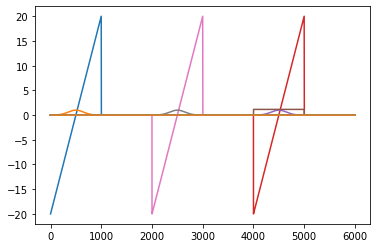

In [126]:
# Extract Pulse samples for local channel
for x in local_samples:
    for y in seq._schedule['local']:
        if type(y.type) == Pulse and x in y.targets:
            local_samples[x]['amp'][y.ti:y.tf] = y.type.amplitude.samples
            local_samples[x]['det'][y.ti:y.tf] = y.type.detuning.samples
            local_samples[x]['phase'][y.ti:y.tf] = y.type.phase

for x in local_samples:
    plt.plot(times,local_samples[x]['det'])
    plt.plot(times,local_samples[x]['amp'])
    plt.plot(times,local_samples[x]['phase'])
    
# Define callable coefficient
def amp_coeff(t,args):
    """
    args : contains the qubit id
    """
    return local_samples[args['qubit_id']]['amp'][t]

def det_coeff(t,args):
    """
    args : contains the qubit id
    """
    return local_samples[args['qubit_id']]['det'][t]



Now that we have the samples as arrays, we construct the Hamiltonian objects using 

In [149]:
# Rotations (Using Rotating Wave Approximation):
def ryd_rotate(amplitude, detuning, phase):
    return 0.5*(amplitude*np.cos(phase)*sigma_gr - amplitude*np.sin(phase)*rydY + detuning*rydZ)

def exc_rotate(amplitude, detuning, phase):
    return 0.5*(amplitude*np.cos(phase)*sigma_ge - amplitude*np.sin(phase)*excY + detuning*excZ)


def xterm(t,args): return amplitude[t]*np.cos(phase[t])
def yterm(t,args): return -amplitude[t]*np.sin(phase[t])
def zterm(t,args): return detuning[t]

In [150]:
#Components for the Hamiltonian:
import itertools

#Van der Waals Interaction Terms
VdW = 0
for 
for qubit1 in reg1._ids:
    for qubit2 in reg1._ids[reg1._ids.index(qubit1)+1::]: #Consider only what's after qubit1 in id list
        R = np.sqrt((reg1.qubits[qubit1][0]-reg1.qubits[qubit2][0])**2 + (reg1.qubits[qubit1][1]-reg1.qubits[qubit2][1])**2) 
        VdW += (1/R**6)*two_body_operator(qubit1,qubit2,sigma_rr)

#Rydberg(Global) terms
global_X = 0
global_N = 0
for q_id in reg1._ids:
    global_X += local_operator(q_id,sigma_gr) #global rotation in the Ground-Rydberg basis
    global_N += local_operator(q_id,sigma_rr)

In [155]:
seq.available_channels

{'rydberg_local': Rydberg.Local(Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns, Basis: 'ground-rydberg'),
 'rydberg_local2': Rydberg.Local(Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns, Basis: 'ground-rydberg')}

In [99]:
#Build Hamiltonian
    
# Build Hamiltonian as QobjEvo, using the register's coordinates
H = qutip.QobjEvo( [VdW] ) # Time independent

# Add Global X and N terms with coefficients taken from 'global' channel
H += qutip.QobjEvo( [global_N, np.array(global_det)] , tlist=times  )
H += qutip.QobjEvo( [global_X, np.array(global_amp)] , tlist=times  )

# Add Local terms taken from 'local' channel 
for qubit in reg1.qubits:
    amplitude = local_samples[qubit]['amp']
    detuning = local_samples[qubit]['det']
    H+=qutip.QobjEvo([[local_operator(qubit, sigma_gr), xterm],[local_operator(qubit, rydY), yterm],[local_operator(qubit, rydZ), zterm]], tlist=times)
    H+=qutip.QobjEvo([[local_operator(qubit, sigma_ge), xterm],[local_operator(qubit, excY), yterm],[local_operator(qubit, excZ), zterm]], tlist=times)


We put our functions to work on by evolving the hamiltonian

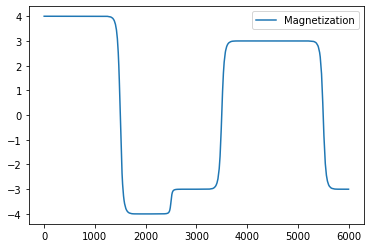

In [102]:
#Evolution using Qutip
initial = qutip.tensor([qutip.basis(3,0) for _ in range(L)])
data = []

# Add magnetization (in Rydberg basis) as observable
observable = 0
for i in range(L):
    observable += local_operator(f'q{i}',rydZ)

result = qutip.sesolve(H, initial, times, [observable]) # Without observables, we get the output state
data = result.expect[0]

plt.plot(times,data,label=f"Magnetization")
plt.legend()

